In [1]:
import pandas as pd
import numpy as np

In [2]:
# COVID-19 cases and deaths as a function of time for multiple countries
# df = pd.read_csv('data/WHO-COVID-19-global-data.csv') # in case the WHO server goes down
df = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')

# convert the date column to datetime objects for easier plotting and manipulation later on
df['Date_reported'] = pd.to_datetime(df['Date_reported'])

In [3]:
# get all the available countries from the data 
availableCountries = df['Country'].unique().tolist()

In [4]:
# I'll also want to take rolling means over 7 day intervals for each country
rollingAve = 7

# The DataFrame is already sorted by country, so I will just go through each country and append to a list
r1 = []
r2 = []
r3 = []
r4 = []
for c in availableCountries:
    usedf =  df.loc[df['Country'] == c]
    r1 += usedf['New_cases'].rolling(rollingAve).mean().to_list()
    r2 += usedf['New_deaths'].rolling(rollingAve).mean().to_list()
    r3 += usedf['Cumulative_cases'].rolling(rollingAve).mean().to_list()
    r4 += usedf['Cumulative_deaths'].rolling(rollingAve).mean().to_list()
df['New_cases_rolling'] = np.nan_to_num(r1)
df['New_deaths_rolling'] = np.nan_to_num(r2)
df['Cumulative_cases_rolling'] = np.nan_to_num(r3)
df['Cumulative_deaths_rolling'] = np.nan_to_num(r4)

In [5]:
%matplotlib widget
import ipympl

import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import mplcursors
from IPython.display import display, clear_output

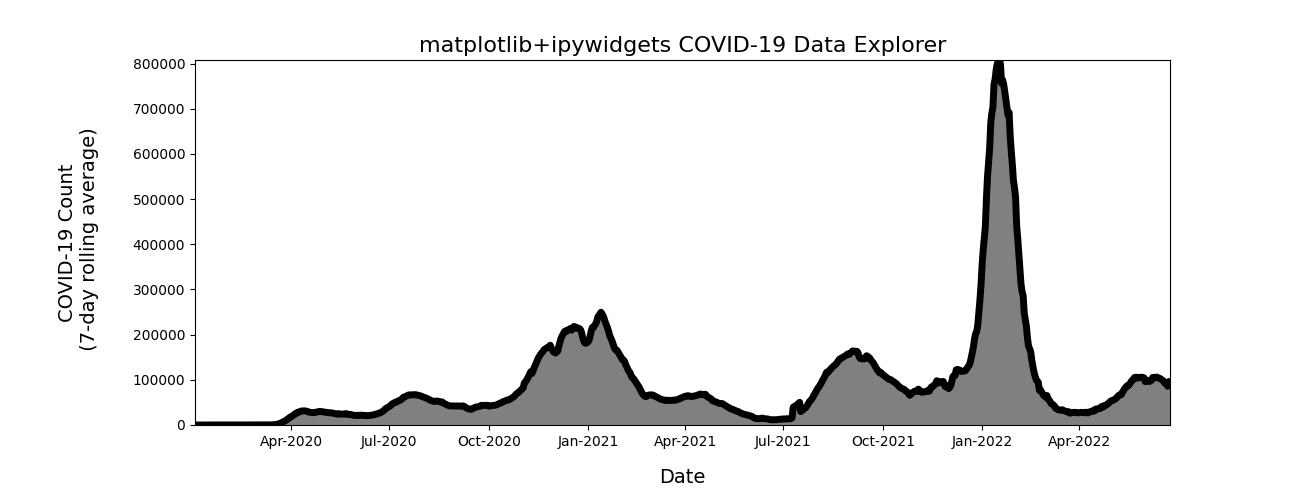

In [6]:
columns = ['New_cases_rolling', 'New_deaths_rolling', 'Cumulative_cases_rolling', 'Cumulative_deaths_rolling']
options = ['Daily Cases', 'Daily Deaths', 'Cumulative Cases' ,'Cumulative Deaths']

country = 'United States of America'
column = 'New_cases_rolling'

# create the initial plot
usedf = df.loc[df['Country'] == country].reset_index(drop = True)

# Create the initial plot with matplotlib
fig, ax = plt.subplots(figsize = (13, 5))
line, = ax.plot(usedf['Date_reported'], usedf[column], color = 'black', linewidth = 5)
filled = ax.fill_between(usedf['Date_reported'], usedf[column], color = 'gray')

# Format the x axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.set_xlim(min(usedf['Date_reported']),max(usedf['Date_reported']))
ax.set_xlabel('Date', fontsize = 14, labelpad = 14)

# Format the y axis
ax.set_ylim(0,max(usedf[column]))
ax.set_ylabel('COVID-19 Count\n (7-day rolling average)', fontsize = 14, labelpad = 24)

# Set the title 
ax.set_title('matplotlib+ipywidgets COVID-19 Data Explorer', fontsize = 16)

# adjust the spacing
fig.subplots_adjust(bottom = 0.15, left = 0.15)

# add tooltips using mplcursors
# https://mplcursors.readthedocs.io/en/stable/examples/hover.html
mplcursors.cursor(hover=True)

plt.show()
# function to update the plot data
def updatePlot(country, column):
    # select the correct country
    usedf = df.loc[df['Country'] == country].reset_index(drop = True)
    
    # replace the data
    # for the line
    line.set_xdata(usedf['Date_reported'])
    line.set_ydata(usedf[column])
    
    # the filled region is a poly collection and required different syntax
    xData = mdates.date2num(usedf['Date_reported'])
    yData = usedf[column].values
    verts = [[x,y] for (x,y) in zip(xData, yData)]
    # close the region
    verts.append([xData[-1],0])
    verts.append([xData[0], 0])
    filled.set_verts([verts])
    
    # redraw the figure
    fig.canvas.draw()
    fig.canvas.flush_events()
    
    # rescale
    ax.set_ylim(0,np.nanmax(usedf[column]))


def changeCountry(change):
    # called when the dropdown menu changes
    global country
    country = change.new
    updatePlot(country, column)

def changeColumn(change):
    # called when the radio buttons changes
    global column
    index = options.index(change.new)
    if (index >= 0):
        column = columns[index]
        updatePlot(country, column)
    else:
        print('bad radio button input', change.new, index)

    
# create the dropdown widget
dropdown = widgets.Dropdown(
    value = country, 
    options = availableCountries, 
    description = ''
)
# when the value changes, execute the callback function "changeCountry".
dropdown.observe(changeCountry, names = 'value')

# create the radio buton and attach them
radiobuttons = widgets.RadioButtons(
    value = 'Daily Cases', 
    options = options, 
    description = ''
)
radiobuttons.observe(changeColumn, names = 'value')


# a VBox container to pack widgets vertically
widgets.VBox(
    [
        dropdown, 
        radiobuttons,
    ]
)